# Albedo Project

**Goal:** Calculate albedo over a one acre area of forest near Tahoe, the albedo for an orchard in Tulare County, and the albedo for a tomato field near Davis.

# Background

### Simple definition

Albedo is the ratio of reflected radiation to incident radiation at a surface. It includes both diffuse and specular reflectivity.

### Surface energy balance

Due to the characteristic absorption of solar radiation by water vapor in the atmosphere, the band that will reach the plants with the least amount of attenuation is the visible spectrum.

The surface energy balance with a few assumptions can be simplified to,
$$ \lambda E = R_{n} - G - H $$
where $\lambda E$ is the energy needed to vaporize water, $R_{n}$ is the net radiation, $G$ is the ground heat flux, $H$ is the sensible heat flux.

<br>

For this project, the component of concern is the net radiation. For the earth's surface,
$$ R_{n} = S_{in} - S_{out} + L_{in} - L_{out} $$
where $S$ denotes shortwave radiation (250 nm to 3 um) and $L$ is longwave radiation (3 to 100 um).

<br>

The outgoing shortwave radiation $S_{out}$ is the portion of shortwave radiation reflected back to the atmosphere, it is characterized in a linear model by the albedo, $r_{0}$,
$$ S_{out} - S_{in} = (1 - r_{0}) \cdot S_{in} $$


**Note:** For remote sensors, the shortwave radiation emitted from the surface has two significant components, reflection of shortwave radiation from clouds, and reflected radiation from the earth's surface.

### Spectral considerations

The various regions of the solar radiation spectrum will interact differently with the earth's surface. Of interest here is the interaction of this radiation with vegetation. In particular, how this radiation influences evapotranspiration (which plants use for cooling and nutrient uptake). 

The most important spectral band to consider is the one that has the strongest influence on evapotranspiration. Looking at the plant reflectance spectrum below, band 3 (green, 525-600 nm) is not reflected strongly and is not absorbed strongly by chlorophyll (i.e., so this region is not involved in photosynthesis). So it is likely that the absorbed energy from band 3 is used in the evaporation process.

Similarly, the dips in the plant reflectance spectrum at 1.4 and 1.9 um are likely due to water absorption and contribute energy to evapotranspiration. However these bands are not monitored by Landsat 8.

Other factors to consider:
1. Spectral regions with potentially stronger surface reflectance will help improve surface-to-noise and dynamic range of the measurement.
1. Ideally would like to minimize signals from other reflectors such as soil and water. Soil reflects weakest in band 1 and 2 however water reflects strongest in band 1 and 2, but at a lower value than soil (see figure below).




### References
1. http://www.intechopen.com/books/evapotranspiration-remote-sensing-and-modeling

### Tables and figures

___
**Plant Reflectance**
<img src="spectral_signatures_landsat.jpg" width="400">
*http://www.seos-project.eu/modules/classification/classification-c00-p05.html*
___
**Plant Absorption**
<img src="pigabs.gif" width="400">
*http://hyperphysics.phy-astr.gsu.edu/hbase/biology/ligabs.html*
___
**Solar Radiation**
<img src="Solar_Spectrum.png" width="300">
*https://en.wikipedia.org/wiki/Solar_irradiance*
___
**Atmospheric Window**
<img src="atmos_win.gif">
*http://earthobservatory.nasa.gov/Features/RemoteSensing/remote_04.php*
___

**Spectral bands from Landsat 8**<br>
Band 1 – Coastal / Aerosol 	0.433 – 0.453 µm<br>
Band 2 – Blue 	0.450 – 0.515 µm<br>
Band 3 – Green 	0.525 – 0.600 µm<br>
Band 4 – Red 	0.630 – 0.680 µm<br>
Band 5 – Near Infrared 	0.845 – 0.885 µm<br>
Band 6 – Short Wavelength Infrared 	1.560 – 1.660 µm<br>
Band 7 – Short Wavelength Infrared 	2.100 – 2.300 µm<br>
Band 8 – Panchromatic 	0.500 – 0.680 µm<br>
Band 9 – Cirrus 	1.360 – 1.390 µm

___

# Acquiring data

*May require login*

- [MODIS Land Data Overview](https://lpdaac.usgs.gov/dataset_discovery/modis)
- [MODIS Tutorial](https://lpdaac.usgs.gov/sites/default/files/public/user_community/docs/opendap_services.html)

## Selecting data source

It seems very likely that the reflected radiation from the earth's surface will be anisotropic with diffuse and specular components. If the purpose is to use the albedo measurement to calculate evapotranspiration over a single day, there doesn't seem to be much utility in deriving the white and black sky components.

*"The MODIS Surface Reflectance products provide an estimate of the surface spectral reflectance as it would be measured at ground level in the absence of atmospheric scattering or absorption. Low-level data are corrected for atmospheric gases and aerosols, yielding a level-2 basis for several higher-order gridded level-2 (L2G) and level-3 products."*

This dataset is named `MOD09GA`.It seems to be the most appropriate as it removes atmospheric effects. 

While the delivered data is averaged over a single day (as requested), the spatial resolution of 500m yields a pixel land area of ~250,000 square meters which is much larger than a single acre (~4000 square meters).

### Why different versions of collected data?

*'A MODIS data "Collection" is basically a MODIS data version. When new & improved science algorithms are developed, the entire MODIS dataset (from launch) is reprocessed and then tagged & distributed as a new "Collection".'*

http://modis-atmos.gsfc.nasa.gov/

Seems to make sense to use the lastest version (`006`) as it is may be favored over older versions (`005`) in future data collection.

## Find appropriate latitude longitude

Using google maps,
1. Tomato field near Davis: 38.620183, -121.859365
1. Orchard in Tulare County: 36.279175, -119.443977
1. Forest near Lake Tahoe: 39.136493, -119.892478

## Find tile containing appropriate data

Two options:
1. Use `ModisTool` to extract latitude longitude values from image files
1. Use API to determine what MODIS tile contains these locations (*faster option*)

<img src="modis_sinusoidal_grid.jpg">



In [3]:
# import libraries

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


In [2]:
# search parameters

prodidver = 'MOD09GA.006'
latlongs = ['38.620183,-121.859365', '36.279175,-119.443977', '39.136493,-119.892478']

apiurl = 'https://lpdaacsvc.cr.usgs.gov/api'
sampleurl = '{0}/sample?'.format(apiurl)

samples = []
for latlong in latlongs:
    sampleargs = {
        'product': prodidver,
        'layer': 'gflags_1', # any layer will do
        'startdate': '01-01-2016',
        'enddate': '01-01-2016',
        'coordinate': latlong,
        'format': 'json'
    }
    samples.append(requests.get(sampleurl, params = sampleargs))

In [76]:
series = [pd.Series(s.json()[0]) for s in samples]
data = pd.concat(series, axis=1).T
print(data.columns)

Index(['Date', 'Latitude', 'Longitude', 'MOD09GA_006_Line_Y_1km',
       'MOD09GA_006_Sample_X_1km', 'MOD09GA_006_gflags_1', 'MODIS_Tile'],
      dtype='object')


In [77]:
data[['Latitude', 'Longitude', 'MODIS_Tile']]

,Latitude,Longitude,MODIS_Tile
0,38.6202,-121.859,h08v05
1,36.2792,-119.444,h08v05
2,39.1365,-119.892,h08v05


So all three locations reside on the same tile.

## Select appropriate day of year

June 1, 2016 seems to be an appropriate time of year to collect surface reflection information from the three regions. For the forest region, there is unlikely to be any snow which might give very different albedo measurements. For the tomato field, the crops should be planted and should still be growing until harvest in late summer. For the orchard, assuming the crops come from deciduous trees, there should be leaves on the tree.

## Download data

MODIS filenames (i.e., the local granule ID) follow a naming convention which gives useful information regarding the specific product. For example, the filename **MOD09A1.A2006001.h08v05.005.2006012234657.hdf** indicates:

- MOD09A1 - Product Short Name
- .A2006001 - Julian Date of Acquisition (A-YYYYDDD)
- .h08v05 - Tile Identifier (horizontalXXverticalYY)
- .005 - Collection Version
- .2006012234567 - Julian Date of Production (YYYYDDDHHMMSS)
- .hdf - Data Format (HDF-EOS)

In [81]:
# lookup filename in the data pool (can code a program to download this if time allows)

poolurl = 'http://e4ftl01.cr.usgs.gov/MOLT/MOD09GQ.006/2016.06.01/'
fname = 'MOD09GQ.A2016153.h08v05.006.2016155063409.hdf'

datareq = requests.get(poolurl+fname)

In [87]:
# save data

with open('data.hdf', 'wb') as f:
    f.write(datareq.content)

output image extents (lat/lon):
- Lat/Long of Upper-Left Corner: ( 39.999999996 -130.540728915 )
- Lat/Long of Upper-Right Corner: ( 39.999999996 -117.486656023 )
- Lat/Long of Lower-Left Corner: ( 29.999999997 -115.470053824 )
- Lat/Long of Lower-Right Corner: ( 29.999999997 -103.923048442 )

size: 1966 lines with 5233 samples

In [78]:
with rasterio.open('MOD09GA.A2016153.h08v05.006.2016155063409.sur_refl_b01_1.tif') as src:
    img1 = src.read()[0]
print('Image size - Rows: {0}, Columns: {1}'.format(img1.shape[0], img1.shape[1]))

Image size - Rows: 1966, Columns: 5233


According to the reference page for this data (*MOD09GA: MODIS/Terra Surface Reflectance Daily L2G Global 1km and 500m SIN Grid V006*), this 16-bit signed integer data must be scaled by a factor of 0.001. Specifically, from the user guide: *"MOD09's  surface  reflectance  values  are  scaled  by  10000  and  then  cast  to  16-bit  integer,  so  surface 
reflectance values in MOD09 files are typically between 0 and 10000."* The valid range is from -100 to 16000, outside this range, the data is useless.

https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod09ga_v006

In [79]:
# scale values

img1 = img1*0.0001

In [90]:
print('Valid range: {0} to {1}'.format(-100*0.0001, 16000*0.0001))
print('Max: {0}, Min: {1}'.format(img1.max(), img1.min()))

Valid range: -0.01 to 1.6
Max: 1.4333, Min: -2.8672


## Retrieve desired pixel values

First, need to determine orientation of image.

In [104]:
# corner 1

img1[:5,:5]

array([[ 0.3257,  0.3257,  0.3354,  0.3354,  0.3228],
       [-2.8672, -2.8672,  0.3435,  0.3435,  0.324 ],
       [-2.8672, -2.8672, -2.8672, -2.8672,  0.3547],
       [-2.8672, -2.8672, -2.8672, -2.8672, -2.8672],
       [-2.8672, -2.8672, -2.8672, -2.8672, -2.8672]])

In [105]:
# corner 2

img1[-5:, :5]

array([[-2.8672, -2.8672, -2.8672, -2.8672, -2.8672],
       [-2.8672, -2.8672, -2.8672, -2.8672, -2.8672],
       [-2.8672, -2.8672, -2.8672, -2.8672, -2.8672],
       [-2.8672, -2.8672, -2.8672, -2.8672, -2.8672],
       [-2.8672, -2.8672, -2.8672, -2.8672, -2.8672]])

In [106]:
# corner 3

img1[:5, -5:]

array([[-2.8672, -2.8672, -2.8672, -2.8672, -2.8672],
       [-2.8672, -2.8672, -2.8672, -2.8672, -2.8672],
       [-2.8672, -2.8672, -2.8672, -2.8672, -2.8672],
       [-2.8672, -2.8672, -2.8672, -2.8672, -2.8672],
       [-2.8672, -2.8672, -2.8672, -2.8672, -2.8672]])

In [107]:
# corner 4

img1[-5:, -5:]

array([[-2.8672, -2.8672, -2.8672, -2.8672, -2.8672],
       [ 0.1619, -2.8672, -2.8672, -2.8672, -2.8672],
       [ 0.1556,  0.1556, -2.8672, -2.8672, -2.8672],
       [ 0.1605,  0.179 ,  0.1842, -2.8672, -2.8672],
       [ 0.1729,  0.153 ,  0.1116,  0.1828, -2.8672]])

Matching the data in the four corners of the array with the image rendered by the `ModisTool`, it appears that corner 1 corresponds to the upper left of the image and corner 4 is the bottom right, corner 2 is then the bottom left and corner 3 is the rop right. This fits when comparing the aspect ratio of the image with the numpy matrix dimensions (1966x5233).

Note that the values `-2.8672` correspond to backfilled values for pixels in the square image where no data was collected.

In [4]:
def findvalues(coords, img):
    # return pixel value from image
    ul = np.array([40.0, -130.5407])
    lr = np.array([30.0, -103.9230])
    scale = ul-lr
    scale[0] = abs(scale[0]/1966)
    scale[1] = abs(scale[1]/5233)
    pxl = []
    for tfcoord, ulcoord, factor in zip(coords, ul, scale):
        pxl.append(int(abs(tfcoord-ulcoord)/factor))
    return img[pxl[0], pxl[1]]

In [124]:
geolocs = [[38.620183, -121.859365], [36.2792, -119.444], [39.136493, -119.892478]]

for name,latlong in zip(['davis tomato field','tulare orchard', 'tahoe forest'], geolocs):
    print(name, ':', findvalues(latlong, img1))

davis tomato field : 0.0674
tulare orchard : 0.1222
tahoe forest : 0.0329


This is the surface reflectance for the first band. For all spectral bands:

In [5]:
# define function to retrieve all values

def remotesr(namebase, numbands=None):
    # spectra names
    spectra = ['620-670', '841-876', '459-479', '545-565', '1230-1250', '1628-1652', '2105-2155']
    # filenames for requested number of bands
    if numbands==None:
        numbands=7
    fnames = [namebase+'.sur_refl_b0'+str(i)+'_1.tif' for i in range(1,1+numbands)]  
    # loop thru names and spectra
    results = []
    for fname,spectrum in zip(fnames, spectra[:numbands+1]):
        with rasterio.open(fname) as src:
            img = src.read()[0]
        img = img*0.0001
        print('')
        print(fname)
        print('Band:', spectrum+'nm')
        geolocs = [[38.620183, -121.859365], [36.2792, -119.444], [39.136493, -119.892478]]
        for name,latlong in zip(['davis tomato field','tulare orchard', 'tahoe forest'], geolocs):
            results.append(findvalues(latlong, img))
            print(name, ':', '{:.4f}'.format(results[-1]))
    return results

In [6]:
res = remotesr('MOD09GA.A2016153.h08v05.006.2016155063409')


MOD09GA.A2016153.h08v05.006.2016155063409.sur_refl_b01_1.tif
Band: 620-670nm
davis tomato field : 0.0674
tulare orchard : 0.1222
tahoe forest : 0.0329

MOD09GA.A2016153.h08v05.006.2016155063409.sur_refl_b02_1.tif
Band: 841-876nm
davis tomato field : 0.2385
tulare orchard : 0.2301
tahoe forest : 0.1327

MOD09GA.A2016153.h08v05.006.2016155063409.sur_refl_b03_1.tif
Band: 459-479nm
davis tomato field : 0.0317
tulare orchard : 0.0651
tahoe forest : 0.0184

MOD09GA.A2016153.h08v05.006.2016155063409.sur_refl_b04_1.tif
Band: 545-565nm
davis tomato field : 0.0633
tulare orchard : 0.0986
tahoe forest : 0.0313

MOD09GA.A2016153.h08v05.006.2016155063409.sur_refl_b05_1.tif
Band: 1230-1250nm
davis tomato field : 0.2310
tulare orchard : 0.2850
tahoe forest : 0.1364

MOD09GA.A2016153.h08v05.006.2016155063409.sur_refl_b06_1.tif
Band: 1628-1652nm
davis tomato field : 0.1833
tulare orchard : 0.2922
tahoe forest : 0.1147

MOD09GA.A2016153.h08v05.006.2016155063409.sur_refl_b07_1.tif
Band: 2105-2155nm
davi

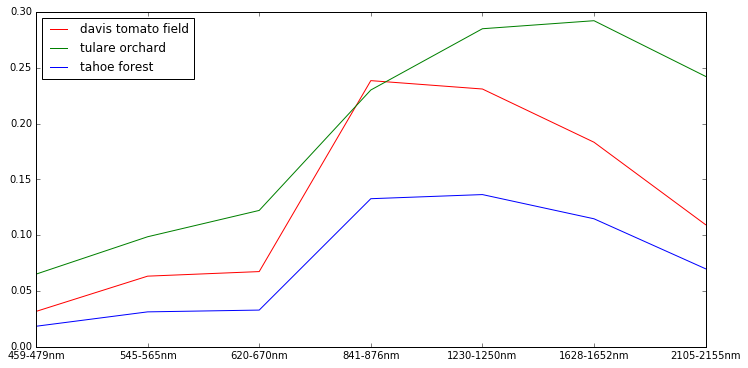

In [36]:
# plot of data

yys = np.array(res).reshape(-1,3)
xx = np.linspace(1,7,7, dtype=int)

lbls = ['davis tomato field','tulare orchard', 'tahoe forest']
df = pd.DataFrame(yys, columns=lbls)
df['band'] = [620, 841, 459, 545, 1230, 1628, 2105]
xlbls = dict(zip(df['band'].tolist(), 
                      ['620-670nm', '841-876nm', '459-479nm', '545-565nm', 
                       '1230-1250nm', '1628-1652nm', '2105-2155nm']))
df.sort_values('band', inplace=True)

clrs = ['red', 'green', 'blue']

f = plt.figure(figsize=(12,6))

for idx in range(yys.shape[1]):
    plt.plot(xx, df[lbls[idx]], c=clrs[idx], label=lbls[idx])
plt.legend(loc='best')
_ = plt.xticks(xx, [xlbls[band] for band in df['band']])

The spectral region of interest here is band 3 (545-565nm):
- davis tomato field : 0.0633
- tulare orchard : 0.0986
- tahoe forest : 0.0313

This values seem to agree with expectations for the plant reflectance spectrum and references [1]. The forest region is expected to have the lowest albedo since it is very dense with tall conifers(some deciduous), next lowest would be the dense shrub-like tomato plants and the highest reflectance would likely be the orchard.

**Possible problems**
1. The 500m spatial resolution of may not be homogenous, actually contains a mixture of vegetations.
1. The forest near tahoe may have steep inclines/declines that violate the assumption of a flat surface. This could create shadows or change the angle of reflection.

**References**
1. Coakley, J.A., Jr., 2002: Reflectance and albedo, surface. Encyclopedia of the Atmosphere. J.R. Holton and J.A. Curry, Eds. Academic Press. 1914-1923

### Comparison with Albedo measurements reported as part of the LP DAAC

*"The models support the spatial relationship and parameter characterization best describing the differences in radiation due to the scattering (anisotropy) of each pixel, relying on multi-date, atmospherically corrected, cloud-cleared input data measured over 16-day periods. Both Terra and Aqua data are used in the generation of this product, providing the highest probability for quality input data."*

In [86]:
with rasterio.open('MCD43A3.A2016149.h08v05.006.2016181042723.Albedo_WSA_Band1.tif') as src:
    imgwsa = src.read()[0]
print('Image size - Rows: {0}, Columns: {1}'.format(imgwsa.shape[0], imgwsa.shape[1]))

Image size - Rows: 1966, Columns: 5233


In [87]:
imgwsa = imgwsa*0.001

In [94]:
print('Valid range: {0} to {1}'.format(0, 32766*0.001))
print('Max: {0}, Min: {1}'.format(imgwsa.max(), imgwsa.min()))

Valid range: 0 to 32.766
Max: 32.767, Min: 0.0


In [98]:
serwsa = pd.Series(imgwsa.flatten())
print('{0:,} bad values out of {1:,}'.format(len(serwsa[serwsa==32.767]), len(serwsa)))

6,476,677 bad values out of 10,288,078


In [125]:
geolocs = [[38.620183, -121.859365], [36.2792, -119.444], [39.136493, -119.892478]]

for name,latlong in zip(['davis tomato field','tulare orchard', 'tahoe forest'], geolocs):
    print(name, ':', findvalues(latlong, imgwsa))

davis tomato field : 0.085
tulare orchard : 0.126
tahoe forest : 0.034


In [139]:
with rasterio.open('MCD43A3.A2016149.h08v05.006.2016181042723.Albedo_BSA_Band1.tif') as src:
    imgbsa = src.read()[0]
imgbsa = imgbsa*0.001
    
geolocs = [[38.620183, -121.859365], [36.2792, -119.444], [39.136493, -119.892478]]

for name,latlong in zip(['davis tomato field','tulare orchard', 'tahoe forest'], geolocs):
    print(name, ':', findvalues(latlong, imgbsa))

davis tomato field : 0.071
tulare orchard : 0.115
tahoe forest : 0.034


In [153]:
# define function to retrieve all values

def remotealbedo(namebase, sky, numbands=None):
    # spectra names
    spectra = ['620-670', '841-876', '459-479', '545-565', '1230-1250', '1628-1652', '2105-2155']
    # filenames for requested number of bands
    if numbands==None:
        numbands=7
    fnames = [namebase+'.Albedo_'+sky.upper()+'_Band'+str(i)+'.tif' for i in range(1,1+numbands)]  
    # loop thru names and spectra
    for fname,spectrum in zip(fnames, spectra[:numbands+1]):
        with rasterio.open(fname) as src:
            img = src.read()[0]
        img = img*0.001
        print('')
        print(fname)
        print('Band:', spectrum+'nm')
        geolocs = [[38.620183, -121.859365], [36.2792, -119.444], [39.136493, -119.892478]]
        for name,latlong in zip(['davis tomato field','tulare orchard', 'tahoe forest'], geolocs):
            print(name, ':', '{:.4f}'.format(findvalues(latlong, img)))
    return

In [154]:
remotealbedo('MCD43A3.A2016149.h08v05.006.2016181042723', 'BSA')


MCD43A3.A2016149.h08v05.006.2016181042723.Albedo_BSA_Band1.tif
Band: 620-670nm
davis tomato field : 0.0710
tulare orchard : 0.1150
tahoe forest : 0.0340

MCD43A3.A2016149.h08v05.006.2016181042723.Albedo_BSA_Band2.tif
Band: 841-876nm
davis tomato field : 0.2450
tulare orchard : 0.2480
tahoe forest : 0.1610

MCD43A3.A2016149.h08v05.006.2016181042723.Albedo_BSA_Band3.tif
Band: 459-479nm
davis tomato field : 0.0360
tulare orchard : 0.0640
tahoe forest : 0.0170

MCD43A3.A2016149.h08v05.006.2016181042723.Albedo_BSA_Band4.tif
Band: 545-565nm
davis tomato field : 0.0670
tulare orchard : 0.0970
tahoe forest : 0.0340

MCD43A3.A2016149.h08v05.006.2016181042723.Albedo_BSA_Band5.tif
Band: 1230-1250nm
davis tomato field : 0.2370
tulare orchard : 0.2750
tahoe forest : 0.1430

MCD43A3.A2016149.h08v05.006.2016181042723.Albedo_BSA_Band6.tif
Band: 1628-1652nm
davis tomato field : 0.1840
tulare orchard : 0.2740
tahoe forest : 0.1190

MCD43A3.A2016149.h08v05.006.2016181042723.Albedo_BSA_Band7.tif
Band: 21

In [155]:
remotealbedo('MCD43A3.A2016149.h08v05.006.2016181042723', 'WSA')


MCD43A3.A2016149.h08v05.006.2016181042723.Albedo_WSA_Band1.tif
Band: 620-670nm
davis tomato field : 0.0850
tulare orchard : 0.1260
tahoe forest : 0.0340

MCD43A3.A2016149.h08v05.006.2016181042723.Albedo_WSA_Band2.tif
Band: 841-876nm
davis tomato field : 0.3140
tulare orchard : 0.2840
tahoe forest : 0.2070

MCD43A3.A2016149.h08v05.006.2016181042723.Albedo_WSA_Band3.tif
Band: 459-479nm
davis tomato field : 0.0420
tulare orchard : 0.0700
tahoe forest : 0.0160

MCD43A3.A2016149.h08v05.006.2016181042723.Albedo_WSA_Band4.tif
Band: 545-565nm
davis tomato field : 0.0800
tulare orchard : 0.1110
tahoe forest : 0.0370

MCD43A3.A2016149.h08v05.006.2016181042723.Albedo_WSA_Band5.tif
Band: 1230-1250nm
davis tomato field : 0.2990
tulare orchard : 0.3240
tahoe forest : 0.1630

MCD43A3.A2016149.h08v05.006.2016181042723.Albedo_WSA_Band6.tif
Band: 1628-1652nm
davis tomato field : 0.2160
tulare orchard : 0.3110
tahoe forest : 0.1370

MCD43A3.A2016149.h08v05.006.2016181042723.Albedo_WSA_Band7.tif
Band: 21

<br>
___

# Supplemental

Acquire individual pixel data through API rather than large image files

In [40]:
# import libraries

import requests
import pandas as pd

In [23]:
SERVICES_URL = 'https://lpdaacsvc.cr.usgs.gov/api'
products_req = requests.get('{0}/product?rasterType=tile&format=json'.format(SERVICES_URL))
products = products_req.json()

print('Information was found for {0} products'.format(len(products)))
products[0].keys()

Information was found for 85 products


dict_keys(['TemporalGranularity', 'Available', 'ProductAndVersion', 'Resolution', 'DocLink', 'Platform', 'RasterType', 'Product', 'Description', 'Version'])

In [72]:
# possible satellite filters 'MOD' for Terra, 'MYD' for Aqua, 'MCD' for Composite (both)

pd.DataFrame([[p['Platform'],p['Product'], p['Description']] for p in products])


,0,1,2
0,Combined MODIS,MCD12Q1,Land Cover Type
1,Combined MODIS,MCD12Q2,Land Cover Dynamics
2,Combined MODIS,MCD15A2,Leaf Area Index - FPAR
3,Combined MODIS,MCD15A2H,Leaf Area Index and Fractional Photosynthetica...
4,Combined MODIS,MCD15A3,Leaf Area Index - FPAR
5,Combined MODIS,MCD15A3H,Leaf Area Index and Fractional Photosynthetica...
6,Combined MODIS,MCD43A1,BRDF-Albedo Model Parameters
7,Combined MODIS,MCD43A2,BRDF-Albedo Quality
8,Combined MODIS,MCD43A3,Albedo
9,Combined MODIS,MCD43A4,Nadir BRDF-Adjusted Reflectance


In [7]:
# select specific product for surface reflectance

prodid = 'MOD09GA'

[p for p in products if p['Product'] == prodid]

[{'Available': True,
  'Description': 'Surface Reflectance Bands 1-7',
  'DocLink': 'https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod09ga',
  'Platform': 'Terra MODIS',
  'Product': 'MOD09GA',
  'ProductAndVersion': 'MOD09GA.005',
  'RasterType': 'Tile',
  'Resolution': '500/1000m',
  'TemporalGranularity': 'Daily',
  'Version': '005'},
 {'Available': True,
  'Description': 'Reflectance',
  'DocLink': 'https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod09ga_v006',
  'Platform': 'Terra MODIS',
  'Product': 'MOD09GA',
  'ProductAndVersion': 'MOD09GA.006',
  'RasterType': 'Tile',
  'Resolution': '500/1000m',
  'TemporalGranularity': 'Daily',
  'Version': '006'}]

In [24]:
prodidver = 'MOD09GA.006'

product_layers_req = requests.get('{0}/product/{1}?format=json'.format(SERVICES_URL, prodidver))
product_layers = product_layers_req.json()
print('This product contains {0} layers'.format(len(product_layers)))
product_layers[0].keys()

This product contains 21 layers


dict_keys(['Dimensions', 'XSize', 'QualityLayers', 'Available', 'QualityProductAndVersion', 'ValidMax', 'Description', 'FillValue', 'YSize', 'ValidMin', 'Layer', 'DataType'])

In [17]:
[[p['Layer'], p['Description']] for p in product_layers]

[['gflags_1', 'Geolocation flags'],
 ['granule_pnt_1', 'Granule Pointer'],
 ['iobs_res_1', 'observation number in coarser grid'],
 ['num_observations_1km', 'Number of Observations'],
 ['obscov_500m_1', 'Observation coverage'],
 ['orbit_pnt_1', 'Orbit pointer'],
 ['q_scan_1', '250m scan value information'],
 ['QC_500m_1', '500m Reflectance Band Quality'],
 ['Range_1', 'Range (pixel to sensor)'],
 ['SensorAzimuth_1', 'Sensor azimuth'],
 ['SensorZenith_1', 'Sensor zenith'],
 ['SolarAzimuth_1', 'Solar azimuth'],
 ['SolarZenith_1', 'Solar zenith'],
 ['state_1km_1', '1km Reflectance Data State QA'],
 ['sur_refl_b01_1', '500m Surface Reflectance Band 1'],
 ['sur_refl_b02_1', '500m Surface Reflectance Band 2'],
 ['sur_refl_b03_1', '500m Surface Reflectance Band 3'],
 ['sur_refl_b04_1', '500m Surface Reflectance Band 4'],
 ['sur_refl_b05_1', '500m Surface Reflectance Band 5'],
 ['sur_refl_b06_1', '500m Surface Reflectance Band 6'],
 ['sur_refl_b07_1', '500m Surface Reflectance Band 7']]

In [52]:
# layers

print([p['Layer'] for p in product_layers])

['gflags_1', 'granule_pnt_1', 'iobs_res_1', 'num_observations_1km', 'obscov_500m_1', 'orbit_pnt_1', 'q_scan_1', 'QC_500m_1', 'Range_1', 'SensorAzimuth_1', 'SensorZenith_1', 'SolarAzimuth_1', 'SolarZenith_1', 'state_1km_1', 'sur_refl_b01_1', 'sur_refl_b02_1', 'sur_refl_b03_1', 'sur_refl_b04_1', 'sur_refl_b05_1', 'sur_refl_b06_1', 'sur_refl_b07_1']


In [67]:
layerids =  ['SensorAzimuth_1', 'SensorZenith_1', 'SolarAzimuth_1', 'SolarZenith_1', 'state_1km_1', 
             'sur_refl_b01_1', 'sur_refl_b02_1', 'sur_refl_b03_1', 'sur_refl_b04_1', 'sur_refl_b05_1', 
             'sur_refl_b06_1', 'sur_refl_b07_1']

latlongs = ['38.620183,-121.859365', '36.279175,-119.443977', '39.136493,-119.892478']

samples = []
sample_url = '{0}/sample?'.format(SERVICES_URL)

for latlong in latlongs:
    for layerid in layerids:
        sample_args = {
            'product': prodidver,
            'layer': layerid,
            'startdate': '06-01-2016',
            'enddate': '06-01-2016',
            'coordinate': latlong,
            'format': 'json'
        }
        samples.append(requests.get(sample_url, params = sample_args))

In [68]:
print(len(samples))
samples[0].json()[0]

36


{'Date': '2016-06-01T00:00:00.000Z',
 'Latitude': 38.620183,
 'Longitude': -121.859365,
 'MOD09GA_006_Line_Y_1km': 165,
 'MOD09GA_006_Sample_X_1km': 574,
 'MOD09GA_006_SensorAzimuth_1': -79.0,
 'MODIS_Tile': 'h08v05'}

In [71]:
# series = [pd.Series(s.json()[0]) for s in samples]
# data = pd.concat(series, axis=1).T
# data.info()
# data